In [3]:
#set the base path of the EW_Model folder
base_path = r'C:\Users\Utente\OneDrive - Princeton University\Codes'

In [4]:
import os
import time; start_time = time.time()
import importlib as imp
import pyEW
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import warnings
import pandas as pd
import json
# Set Arial as the default font family
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})

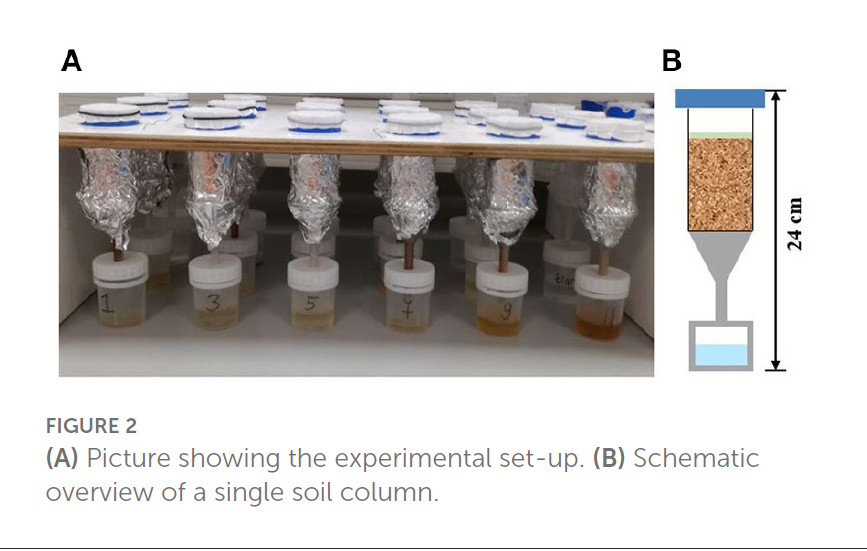

In [11]:
#experimental files
file_path1 = os.path.join(base_path, 'EW_Model', 'Exp_Data', 'tePas_Frontier_2023', 'pH_vs_t.json')
file_path2 = os.path.join(base_path, 'EW_Model', 'Exp_Data', 'tePas_Frontier_2023', 'Alk_cum_vs_t.json')
file_path3 = os.path.join(base_path, 'EW_Model', 'Exp_Data', 'tePas_Frontier_2023', 'CDF.json')

with open(file_path1, 'r') as json_file:
    data_exp_pH = json.load(json_file)

with open(file_path2, 'r') as json_file:
    data_exp_Alk_cum = json.load(json_file)
    
with open(file_path3, 'r') as json_file:
    data_exp_CDF = json.load(json_file)

data_exp = {'rock': ['control','olivine','basalt', 'wollastonite', 'anorthite', 'albite'],
        'base_sat_1': [0.41, 0.78, 0.75, 0.80, 0.40, 0.60], # [%]
        'base_sat_2': [0.41, 0.88, 0.60, 0.82, 0.45, 0.65], 
        'CEC_1': [20, 40, 32, 41, 20, 25],  # [mmolc/kg_soil]
        'CEC_2': [20, 47, 25, 34, 22, 28],  
        'CaCO3_1': [ 0.6, 10, 10.2, 12, 4, 1.9],  # [mmol/kg_soil]
        'CaCO3_2': [0.6, 11, 10.5, 12, 2.5, 2.2],  
        'gCO2_mass_bal_1': [np.nan, 1.8,1.6, 2.8, 0.15, 0.3],# [gCO2/kg_soil]
        'gCO2_mass_bal_2': [np.nan, 4.4,0.4, 1.9, 0.3, 0.4],
        'gCO2_alk_carb_1': [np.nan, 0.62, 0.3, 0.52, 0.12, 0.2],
        'gCO2_alk_carb_2': [np.nan, 0.58, 0.4, 0.48, 0.08, 0.1]}

tePas_exp = pd.DataFrame(data_exp)
print(tePas_exp)

           rock  base_sat_1  base_sat_2  CEC_1  CEC_2  CaCO3_1  CaCO3_2  \
0       control        0.41        0.41     20     20      0.6      0.6   
1       olivine        0.78        0.88     40     47     10.0     11.0   
2        basalt        0.75        0.60     32     25     10.2     10.5   
3  wollastonite        0.80        0.82     41     34     12.0     12.0   
4     anorthite        0.40        0.45     20     22      4.0      2.5   
5        albite        0.60        0.65     25     28      1.9      2.2   

   gCO2_mass_bal_1  gCO2_mass_bal_2  gCO2_alk_carb_1  gCO2_alk_carb_2  
0              NaN              NaN              NaN              NaN  
1             1.80              4.4             0.62             0.58  
2             1.60              0.4             0.30             0.40  
3             2.80              1.9             0.52             0.48  
4             0.15              0.3             0.12             0.08  
5             0.30              0.4       

In [12]:
# time 
t_end = 64 # [d]: number of simulated days
dt = 1/(24*60) # [time resolution (d)]
t=np.arange(0,t_end,dt)

#units
conv_mol = 1e6 # Conversion from moles to micromols 
conv_Al = 1e3 # Conversion for Al species from mols to nanomols

#water balance
keyword_wb = 1 # 1 = varying soil moisture. 0 = constant soil moisture

#background inputs of cations and anions
keyword_add = 0 # 1 = balance background losses. 0 = no addition

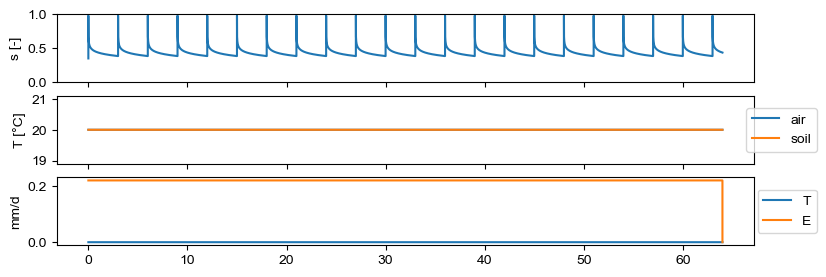

In [13]:
# HYDROCLIMATE AND WATER BALANCE

#soil 
soil = "sand" #sand, loamy sand, sandy loam, loam

rho_bulk = 1.0*1e6 #soil dry mass (g/m3)
V_container = 180*1e-6 # [m3]
h_container = 0.12 # [m]
A_container = V_container/h_container # [m2]
m_soil = 150 #[g]
Zr = m_soil/(rho_bulk*A_container) # [m]: soil depth
s_in = 0.35

#hydroclimatic
day1 = 180 #initial day for the simulation
latitude = 43.5*np.pi/180 # [radians]
albedo = 0.25
altitude = 10 #[m]
wind = 0.1*np.ones(len(t)) #[m/s]
coastal = False 
temp_av = 20 # [°C] yearly average
temp_ampl_yr= 0 # [°C] yearly amplitude
temp_ampl_d= 0 # [°C] daily amplitude

#vegetation
T_v = 40 # [d] growth time
k_v = 500 # [g/m2] carrying capacity
RAI = 5 #[m2/m2] root area index
root_d = 0.4*1e-3 #[m] average root diameter
v_in = 0 # [g/m2] ic
t0_v = 0 # [d] starting day of growth

#temp [Celsius]
[temp_air,temp_soil,temp_min,temp_max] = pyEW.temp(latitude,temp_av, temp_ampl_yr, temp_ampl_d, Zr,t_end,dt,day1)

#ET0 [m/d]
ET0 = pyEW.ET0(latitude,altitude,temp_air,temp_soil,temp_min,temp_max, wind,albedo,Zr,coastal,t_end,dt,day1)

#deterministic rain [m]
Rain_event = 40 # [ml]
Rain_event = Rain_event*1e-6/A_container # [m]
t_rain = 3 #[d]: between rain event
rain = np.zeros(len(t))
j = 1
while j < len(rain):
    rain[j] = Rain_event
    j = j+int(t_rain/dt)
del j

#vegetation [g]
v = pyEW.veg(v_in, T_v, k_v, t0_v, temp_soil, dt)

#moisture balance (I, Q [m], L, T, E [m/d])
[s, s_w, s_i, I, L, T, E, Q, Irr, n] = pyEW.moisture_balance(rain, Zr, soil, ET0, v, k_v, keyword_wb, s_in,t_end,dt)

# Figure
fig, axs = plt.subplots(3, 1,figsize=(9, 3))

axs[0].plot(t,s)
axs[0].set_xticklabels([])
axs[0].set_ylabel('s [-]')
axs[0].set_ylim(0,1)

axs[1].plot(t,temp_air,label='air')
axs[1].plot(t,temp_soil,label='soil')
axs[1].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
axs[1].set_ylabel('T [°C]')
axs[1].set_xticklabels([])

axs[2].plot(t,T*1000, label ='T')
axs[2].plot(t,E*1000, label ='E')
axs[2].set_ylabel('mm/d')
axs[2].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))

#print(np.trapz(E,t),np.trapz(L,t))
plt.show()

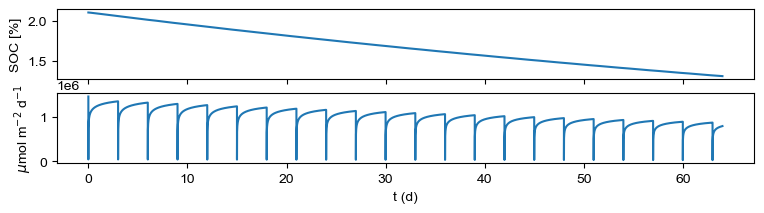

In [14]:
# ORGANIC CARBON and RESPIRATION

#initial pCO2
CO2_air_in = 50*pyEW.CO2_atm(conv_mol) # [mol-conv/l] 
ratio_aut_het = 0

#Initial organic carbon
ADD = 0 # added dry litter [gOC/(m2*d)]
SOC_in = rho_bulk*2.1/100 #[gOC/m3] 

#SOC balance and respiration
[SOC, r_het, r_aut, D] = pyEW.respiration(ADD, SOC_in, CO2_air_in, ratio_aut_het, soil, s, v, k_v, Zr, temp_soil,dt,conv_mol)

# figure
fig, axs = plt.subplots(2, 1,figsize=(9, 2))

axs[0].plot(t,100*SOC/(rho_bulk),label='crop')
axs[0].set_xticklabels([])
axs[0].set_ylabel('SOC [%]')

axs[1].plot(t, r_het, label = 'resp_het')
axs[1].set_xlabel('t (d)')
axs[1].set_ylabel('$\mu$mol m$^{-2}$ d$^{-1}$')

plt.show()

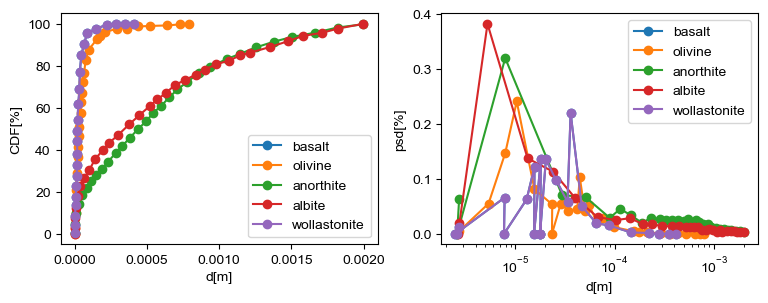

In [15]:
#particle size distribution (from digitized data)
def process_CDF(data_exp_CDF, name):
    CDF_data = next(dataset for dataset in data_exp_CDF["datasetColl"] if dataset["name"] == name)
    d_in = 1e-6*np.array([point['value'][0] for point in CDF_data['data']])
    CDF_in = np.array([point['value'][1] for point in CDF_data['data']])
    psd_in = np.diff(CDF_in)/np.diff(d_in)
    psd_in[psd_in < 0] = 0
    psd_in = np.insert(psd_in, 0, CDF_in[0]/d_in[0])
    psd_in /= np.sum(psd_in)
    return d_in, CDF_in, psd_in

names = ["basalt", "olivine", "anorthite", "albite"]

fig, axs = plt.subplots(1, 2, figsize=(9, 3))

for name in names:
    d_in, CDF_in, psd_in = process_CDF(data_exp_CDF, name)
    axs[0].plot(d_in, CDF_in, marker='o', label=name)

    axs[1].plot(d_in, psd_in, marker='o', label=name)

#wollastonite psd is same as basalt
d_in, CDF_in, psd_in = process_CDF(data_exp_CDF, "basalt")
axs[0].plot(d_in, CDF_in, marker='o', label="wollastonite")
axs[1].plot(d_in, psd_in, marker='o', label="wollastonite")

#figure
axs[0].set_xlabel('d[m]')
axs[0].set_ylabel('CDF[%]')
axs[0].legend()

axs[1].set_xlabel('d[m]')
axs[1].set_ylabel('psd[%]')
axs[1].set_xscale('log')
axs[1].legend()

plt.show()

In [17]:
# SOIL BIOGEOCHEMISTRY

[MM_Mg, MM_Ca, MM_Na, MM_K, MM_Si, MM_carbon, MM_Anions, MM_Al]=pyEW.MM(conv_mol) 

#initial pH
pH_in = 5.2

#total [mol/m2]
Ca_tot_in = 214*1e-6*rho_bulk*Zr/MM_Ca #mg/kg_soil converted to mol-conv/m2
Mg_tot_in = 34.7*1e-6*rho_bulk*Zr/MM_Mg
K_tot_in = 40*1e-6*rho_bulk*Zr/MM_K
Na_tot_in = 9*1e-6*rho_bulk*Zr/MM_Na
total_in = [Ca_tot_in, Mg_tot_in, K_tot_in, Na_tot_in]

Si_in = 0

#carbonates [micromol/m2]
CaCO3_in = 0.38*(rho_bulk*1e-3*Zr)*conv_mol/100 - 32350 #TIC measured - IC_tot_in (simulated)
MgCO3_in = 0

#Effective CEC (measured)
CEC_tot = 3 # [mmol_c / 100 g dry-soil]
CEC_tot = CEC_tot*1e-5*rho_bulk*Zr*conv_mol # [mol_c]

#base saturation
f_base_CEC= 0.31
f_acid_CEC= 1 - f_base_CEC

#estimated conc water and CEC fractons
[conc_in, f_CEC_in, K_CEC] = pyEW.total_to_f_CEC_and_conc(total_in,pH_in,f_acid_CEC, s, soil,n,Zr,CEC_tot,conv_mol,conv_Al)
if abs(sum(f_CEC_in)-1) > 1e-6:
    raise ValueError("Sum of fractions must be 1")

# olivine application
M_rock_in = 18.75/A_container # [g/m2] of added rock powder
mineral = ["forsterite"] 
rock_f_in = np.array([0.43/0.57]) #only a fraction is actually the pure mineral, see paper
d_in, CDF_in, psd_perc_in = process_CDF(data_exp_CDF, "olivine")
SSA_in = 3.7 # [m2/g]: measured ssa
diss_f = 0.2 #dissolution factor
t_app = 0 # day of application
data_ol = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# basalt application
mineral = ["labradorite", "augite", "forsterite"] 
rock_f_in = np.array([0.4,0.2,0.1]) #Beerling 2020
d_in, CDF_in, psd_perc_in = process_CDF(data_exp_CDF, "basalt")
SSA_in = 3.88 # m2/g
diss_f = 0.2 #dissolution factor
data_ba = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# wollastonite application
mineral = ["wollastonite"]
rock_f_in = np.array([0.26/0.48])
d_in, CDF_in, psd_perc_in = process_CDF(data_exp_CDF, "basalt") #same psd as basalt
SSA_in = 1.49 # m2/g
diss_f = 0.015
data_wo = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# anorthite application
mineral = ["anorthite"] 
rock_f_in = np.array([0.11/0.19])
d_in, CDF_in, psd_perc_in = process_CDF(data_exp_CDF, "anorthite")
SSA_in = 0.64 # m2/g
diss_f = 0.01
data_an = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# albite application
mineral = ["albite","wollastonite"] 
rock_f_in = np.array([0.97, 0.03])
d_in, CDF_in, psd_perc_in = process_CDF(data_exp_CDF, "albite")
SSA_in = 1.13 # m2/g
diss_f = 0.05 #dissolution factor
data_al = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# Control Application
M_rock_in = 0
data_untr = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

C:\Users\Utente\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


In [18]:
# NUMERICAL

#--------------------------------------------
# Alk in leachate and pH - moving averages
#--------------------------------------------
win_size = int(3/dt) #moving average time interval

Alk_t_avg = A_container*np.array([pyEW.mov_avg(np.cumsum(data_untr['Alk']*L*dt),win_size), # [mmol_c per column]
                                  pyEW.mov_avg(np.cumsum(data_ol['Alk']*L*dt),win_size),
                                  pyEW.mov_avg(np.cumsum(data_ba['Alk']*L*dt),win_size),
                                  pyEW.mov_avg(np.cumsum(data_wo['Alk']*L*dt),win_size),
                                  pyEW.mov_avg(np.cumsum(data_an['Alk']*L*dt),win_size),
                                  pyEW.mov_avg(np.cumsum(data_al['Alk']*L*dt),win_size)])

pH_t_avg = np.array([pyEW.mov_avg(data_untr['pH'],win_size),
                     pyEW.mov_avg(data_ol['pH'],win_size),
                     pyEW.mov_avg(data_ba['pH'],win_size),
                     pyEW.mov_avg(data_wo['pH'],win_size),
                     pyEW.mov_avg(data_an['pH'],win_size),
                     pyEW.mov_avg(data_al['pH'],win_size)])

#--------------------------------------------
# Alk in CEC
#--------------------------------------------

Alk_CEC = [data_untr['f_Ca']+data_untr['f_Mg']+data_untr['f_Na']+data_untr['f_K'],
          data_ol['f_Ca']+data_ol['f_Mg']+data_ol['f_Na']+data_ol['f_K'],
          data_ba['f_Ca']+data_ba['f_Mg']+data_ba['f_Na']+data_ba['f_K'],
          data_wo['f_Ca']+data_wo['f_Mg']+data_wo['f_Na']+data_wo['f_K'],
          data_an['f_Ca']+data_an['f_Mg']+data_an['f_Na']+data_an['f_K'],
          data_al['f_Ca']+data_al['f_Mg']+data_al['f_Na']+data_al['f_K']]
Alk_CEC_final = [(A_container*1e-3*CEC_tot)*row[-1] for row in Alk_CEC] # [mmol_c per column]

#--------------------------------------------
# Potential CO2 capture due to mineral dissolution [gCO2/kg_soil]
#--------------------------------------------

CO2_ol = (data_ol['M_rock'][0]-data_ol['M_rock'][-1])*1.25/(rho_bulk*1e-3*Zr)
CO2_ba = (data_ba['M_rock'][0]-data_ba['M_rock'][-1])*0.38/(rho_bulk*1e-3*Zr) 
CO2_wo = (data_wo['M_rock'][0]-data_wo['M_rock'][-1])*0.76/(rho_bulk*1e-3*Zr)
CO2_al = ((data_al['M_min'][0][0]-data_al['M_min'][0][-1])*0.17
          + (data_al['M_min'][1][0]-data_al['M_min'][1][-1])*0.76)/(rho_bulk*1e-3*Zr) # albite + wollastonite
CO2_an = (data_an['M_rock'][0]-data_an['M_rock'][-1])*0.32/(rho_bulk*1e-3*Zr)
CO2_pot = [0, CO2_ol,CO2_ba, CO2_wo, CO2_an, CO2_al]

#--------------------------------------------
# Effective CO2 capture (for consistency with experimental values, this is not compared to control experiment)
#--------------------------------------------

def CO2_eff_calc(data_IC,data_DIC,data_CaCO3,data_MgCO3):
    delta_DIC_L = np.trapz(data_DIC*1000*L,t) #- np.trapz(data_untr['DIC']*1000*L,t) #[mol-conv/m2]
    delta_IC_s = (data_IC[-1]-data_IC[0]) #- (data_untr['IC_tot'][-1]-data_untr['IC_tot'][0])
    delta_CaCO3 = (data_CaCO3[-1]-data_CaCO3[0]) #- (data_untr['CaCO3'][-1]-data_untr['CaCO3'][0])
    delta_MgCO3 = (data_MgCO3[-1]-data_MgCO3[0]) #- (data_untr['MgCO3'][-1]-data_untr['MgCO3'][0])
    gCO2 = 44*(delta_DIC_L + delta_IC_s + delta_CaCO3 + delta_MgCO3)/(conv_mol*rho_bulk*1e-3*Zr) # [gCO2/kg_soil]
    #gCO2 = 44*(delta_DIC_L)/(conv_mol*rho_bulk*1e-3*Zr) # [gCO2/kg_soil]
    return gCO2

CO2_eff_ol = CO2_eff_calc(data_ol['IC_tot'],data_ol['DIC'],data_ol['CaCO3'],data_ol['MgCO3'])
CO2_eff_ba = CO2_eff_calc(data_ba['IC_tot'],data_ba['DIC'],data_ba['CaCO3'],data_ba['MgCO3'])
CO2_eff_wo = CO2_eff_calc(data_wo['IC_tot'],data_wo['DIC'],data_wo['CaCO3'],data_wo['MgCO3']) 
CO2_eff_al = CO2_eff_calc(data_al['IC_tot'],data_al['DIC'],data_al['CaCO3'],data_al['MgCO3']) 
CO2_eff_an = CO2_eff_calc(data_an['IC_tot'],data_an['DIC'],data_an['CaCO3'],data_an['MgCO3'])
CO2_eff = [0, CO2_eff_ol,CO2_eff_ba, CO2_eff_wo,CO2_eff_an,CO2_eff_al]

In [19]:
# EXPERIMENTAL

#--------------------------------------------
#Alk leached
#--------------------------------------------
all_x_values_Alk = []
all_y_values_Alk = []
series_names = []
series_colors = []
for dataset in data_exp_Alk_cum['datasetColl']:
    x_values_Alk = [point['value'][0] for point in dataset['data']]
    y_values_Alk = [point['value'][1] for point in dataset['data']]
    all_x_values_Alk.append(x_values_Alk)
    all_y_values_Alk.append(y_values_Alk)
    series_names.append(dataset['name'])
    
#--------------------------------------------
# pH dynamics
#--------------------------------------------
# experimental
all_x_values_pH = []
all_y_values_pH = []
series_names_pH = []
series_colors = []
for dataset in data_exp_pH['datasetColl']:
    x_values_pH = [point['value'][0] for point in dataset['data']]
    y_values_pH = [point['value'][1] for point in dataset['data']]
    all_x_values_pH.append(x_values_pH)
    all_y_values_pH.append(y_values_pH)
    series_names.append(dataset['name'])
    series_colors.append(tuple(np.array(dataset['colorRGB'][0:3])/255))

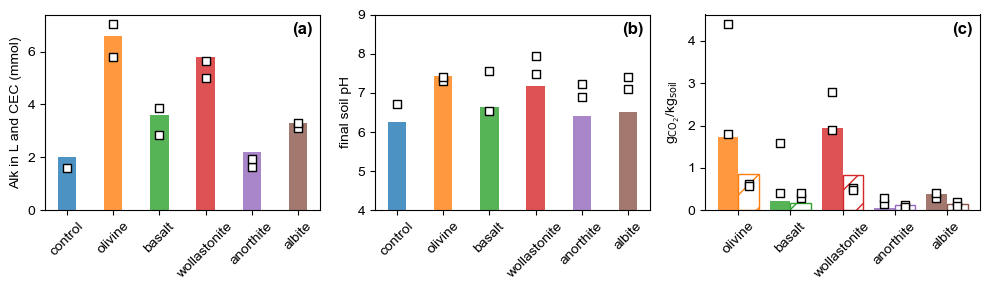

In [20]:
#figure for paper
fig, axs = plt.subplots(1, 3,figsize=(10, 3))
custom_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
categories = ['control', 'olivine', 'basalt', 'wollastonite', 'anorthite', 'albite']
bar_width = 0.4

# -----------------------------------------------------------------------------
# Alk
# -----------------------------------------------------------------------------
x_pos = np.arange(len(categories))

# Numerical
axs[0].bar(x_pos, Alk_t_avg[:, -1] + Alk_CEC_final,
               width=bar_width, align='center', alpha=0.8, color=custom_colors)

# Experimental
axs[0].scatter(x_pos, [sublist[-1] for sublist in all_y_values_Alk][:6] + tePas_exp['base_sat_1']*tePas_exp['CEC_1']*m_soil*1e-3,
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
                
axs[0].scatter(x_pos[1:], [sublist[-1] for sublist in all_y_values_Alk][6:11] + (tePas_exp['base_sat_2']*tePas_exp['CEC_2'])[1:]*m_soil*1e-3,
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
                
# Labels
axs[0].set_xticks(x_pos, labels=categories, rotation=45, fontsize=10)
axs[0].set_ylabel('Alk in L and CEC (mmol)')

#-------------------------------------------------------------------
# pH
#-------------------------------------------------------------------

# Numerical
axs[1].bar(x_pos, pH_t_avg[:, -1], 
           width=bar_width, align='center', alpha=0.8, color=custom_colors)

# Experimental
axs[1].scatter(x_pos, [sublist[-1] for sublist in all_y_values_pH][:6],
                marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[1].scatter(x_pos[1:], [sublist[-1] for sublist in all_y_values_pH][6:11],
                marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)

#labels
axs[1].set_xticks(x_pos, labels=categories, rotation=45, fontsize=10)
axs[1].set_ylim([4,9])
axs[1].set_ylabel('final soil pH')

#---------------------------------------------
# CO2 sequestration
#---------------------------------------------

x_pos_CO2 = np.arange(1,len(categories))

#numerical
axs[2].bar(x_pos_CO2, CO2_pot[1:], width=bar_width, align='center', alpha=0.8, color=custom_colors[1:])
axs[2].bar(x_pos_CO2 + bar_width, CO2_eff[1:], width=bar_width, align='center', hatch='/', edgecolor=custom_colors[1:],
        fill=False)

#experimental potential
axs[2].scatter(x_pos_CO2, tePas_exp['gCO2_mass_bal_1'][1:], 
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[2].scatter(x_pos_CO2, tePas_exp['gCO2_mass_bal_2'][1:], 
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)

#experimental effective
axs[2].scatter(x_pos_CO2 + bar_width, tePas_exp['gCO2_alk_carb_1'][1:], 
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[2].scatter(x_pos_CO2 + bar_width, tePas_exp['gCO2_alk_carb_2'][1:], 
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)

#labels
axs[2].set_xticks(x_pos_CO2 + bar_width / 2,categories[1:],rotation=45, fontsize=10)
axs[2].set_ylabel('g$_{\mathrm{CO}_2}$/kg$_\mathrm{soil}$',fontsize=10)

#panel labels
labels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(axs):
    ax.text(0.9, 0.9, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

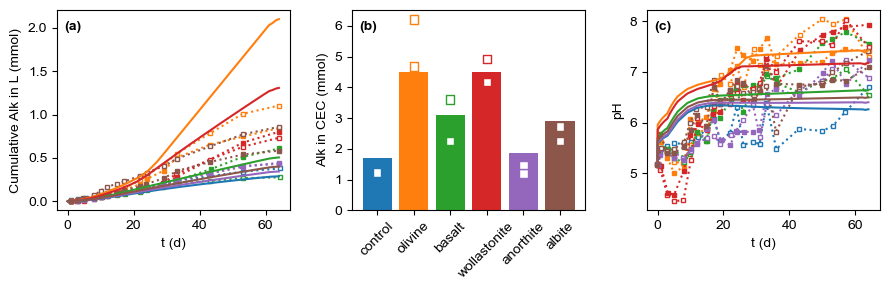

In [21]:
# Cumulative leached alkalinity and pH in time
fig, axs = plt.subplots(1,3,figsize=(9, 3))
    
#------------------------------------------------------------
# CUMULATIVE ALKALINITY
#------------------------------------------------------------
plt.sca(axs[0])
   
#untreated
plt.plot(all_x_values_Alk[0], all_y_values_Alk[0], label=series_names[0], color=custom_colors[0], 
         linestyle=':', markersize=3, markerfacecolor='white', markeredgecolor= custom_colors[0], marker='s', markevery=1) 
for i in range(1,6):
#case 1
    plt.plot(all_x_values_Alk[i], all_y_values_Alk[i], label=series_names[i], color=custom_colors[i], 
             linestyle=':', markersize=3, markerfacecolor='white', markeredgecolor= custom_colors[i], marker='s', markevery=1) 
#case 2
    plt.plot(all_x_values_Alk[i+5], all_y_values_Alk[i+5], label=series_names[i], color=custom_colors[i], 
             linestyle=':', markersize=3, markerfacecolor= custom_colors[i], markeredgecolor= custom_colors[i], marker='s', markevery=1) 

# numerical
for i, row in enumerate(Alk_t_avg):
    plt.plot(t, row, label=categories[i], color=custom_colors[i])

#plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('t (d)', fontsize=10)
plt.ylabel('Cumulative Alk in L (mmol)', fontsize=10)

#------------------------------------------------------------
# Alk in CEC
#------------------------------------------------------------
plt.sca(axs[1])

#numerical (potential CEC)
plt.bar(categories, Alk_CEC_final, color=custom_colors)

#experimental (effective CEC)
plt.scatter(range(len(categories)), tePas_exp['base_sat_1']*tePas_exp['CEC_1']*m_soil*1e-3, 
            marker='s',color ='white', edgecolor= custom_colors)
plt.scatter(range(len(categories)), tePas_exp['base_sat_2']*tePas_exp['CEC_2']*m_soil*1e-3, 
            marker='s',color ='white', edgecolor= custom_colors)

plt.ylabel('Alk in CEC (mmol)', fontsize=10)
plt.xticks(x_pos,categories,rotation=45, fontsize=10)

#------------------------------------------------------------
# pH RESPONSE
#------------------------------------------------------------

plt.sca(axs[2])

#untreated
plt.plot(all_x_values_pH[0], all_y_values_pH[0], color=custom_colors[0], linestyle=':', markersize=3, markerfacecolor='white', markeredgecolor= custom_colors[0], marker='s', markevery=1) 
for i in range(1,6):
    #case 1
    plt.plot(all_x_values_pH[i], all_y_values_pH[i], color=custom_colors[i], linestyle=':', markersize=3, markerfacecolor='white', markeredgecolor= custom_colors[i], marker='s', markevery=1) 
    #case 2
    plt.plot(all_x_values_pH[i+5], all_y_values_pH[i+5], color=custom_colors[i], linestyle=':', markersize=3, markerfacecolor= custom_colors[i], markeredgecolor= custom_colors[i], marker='s', markevery=1) 

    
#numerical
for i, row in enumerate(pH_t_avg):
    plt.plot(t, row, label=categories[i], color=custom_colors[i])

#labels
plt.xlabel('t (d)', fontsize=10)
plt.ylabel('pH', fontsize=10)
#plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

# Add panel labels if needed
axs[0].text(0.03, 0.9, '(a)', transform=axs[0].transAxes, fontsize=10, fontweight='bold')
axs[1].text(0.03, 0.9, '(b)', transform=axs[1].transAxes, fontsize=10, fontweight='bold')
axs[2].text(0.03, 0.9, '(c)', transform=axs[2].transAxes, fontsize=10, fontweight='bold')
    
# Display the plots
plt.tight_layout()
plt.show()

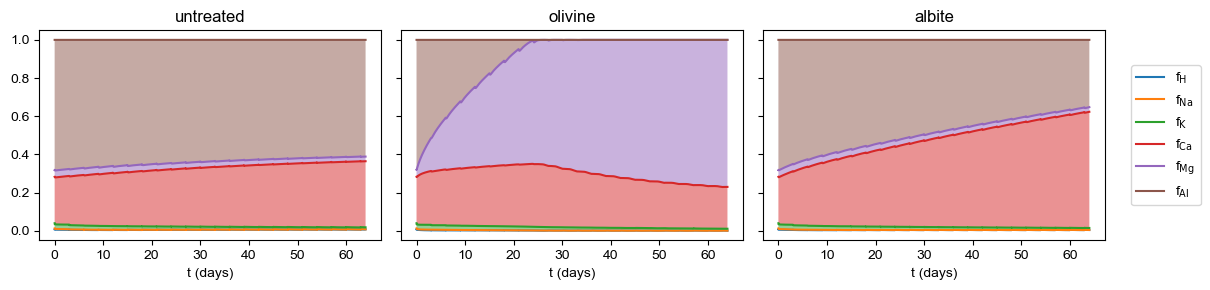

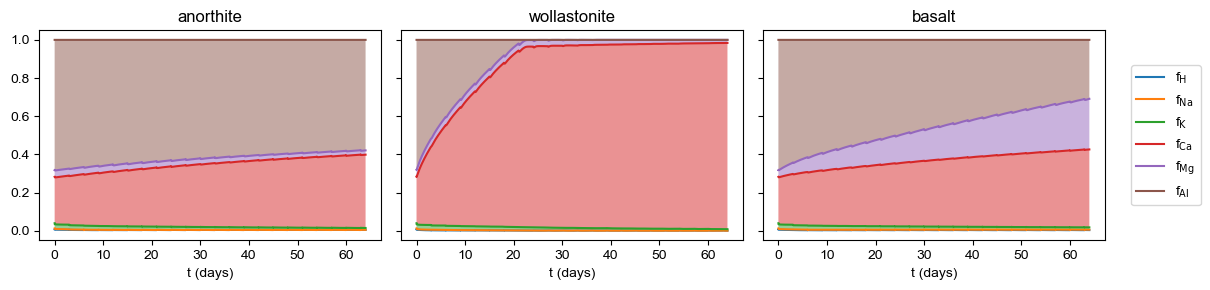

In [22]:
f_Ca_list = [data_untr['f_Ca'], data_ol['f_Ca'], data_al['f_Ca']]
f_Mg_list = [data_untr['f_Mg'], data_ol['f_Mg'], data_al['f_Mg']]
f_K_list = [data_untr['f_K'], data_ol['f_K'], data_al['f_K']]
f_Na_list = [data_untr['f_Na'], data_ol['f_Na'], data_al['f_Na']]
f_Al_list = [data_untr['f_Al'], data_ol['f_Al'], data_al['f_Al']]
f_H_list = [data_untr['f_H'], data_ol['f_H'], data_al['f_H']]
titles = ['untreated', 'olivine', 'albite']
figCEC = pyEW.fig_CEC(t, f_Ca_list, f_Mg_list, f_K_list, f_Na_list, f_Al_list, f_H_list, titles)

f_Ca_list = [data_an['f_Ca'],data_wo['f_Ca'],data_ba['f_Ca']]
f_Mg_list = [data_an['f_Mg'],data_wo['f_Mg'],data_ba['f_Mg']]
f_K_list = [data_an['f_K'],data_wo['f_K'],data_ba['f_K']]
f_Na_list = [data_an['f_Na'],data_wo['f_Na'],data_ba['f_Na']]
f_Al_list = [data_an['f_Al'],data_wo['f_Al'],data_ba['f_Al']]
f_H_list = [data_an['f_H'],data_wo['f_H'],data_ba['f_H']]
titles = ['anorthite', 'wollastonite', 'basalt']
figCEC = pyEW.fig_CEC(t, f_Ca_list, f_Mg_list, f_K_list, f_Na_list, f_Al_list, f_H_list, titles)